## SVM MODEL

Load Dataset

In [1]:
import pandas as pd

# load dataset
df = pd.read_csv('cleaned_Suicide_Detection_with_Token.csv') 

Split Dataset 

In [2]:
from sklearn.model_selection import train_test_split

# split into training and testing sets (70 30)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.3, random_state=42)

Encode Labels

In [3]:
# encode labels (suicide=1 non-suicide=0)
y_train = y_train.map({'suicide': 1, 'non-suicide': 0})
y_test = y_test.map({'suicide': 1, 'non-suicide': 0})

Feature Extractions (TF-IDF Vectorizer)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

SVM Based Model

In [5]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

# SVM baseline model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVC()

Predict Accuracy (SVM Based Model) 

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# predict test 
y_pred = svm_model.predict(X_test_tfidf)

print("SVM Based Model:")

#  training accuracy
trainAccuracy = svm_model.score(X_train_tfidf, y_train)
print("Training Accuracy:", trainAccuracy)

# training loss (MISC)
training_loss = svm_model.score(X_train_tfidf, y_train)
print("Training Loss (MISC):", 1 - training_loss)

# test accuracy
testAccuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", testAccuracy)

# precison recall f1score
print(classification_report(y_test, y_pred))

SVM Based Model:
Training Accuracy: 0.9760174148174793
Training Loss (MISC): 0.02398258518252072
Testing Accuracy: 0.9334780406627595
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     34504
           1       0.94      0.92      0.93     34601

    accuracy                           0.93     69105
   macro avg       0.93      0.93      0.93     69105
weighted avg       0.93      0.93      0.93     69105



Plot Confusion Matrix (SVM Based Model)

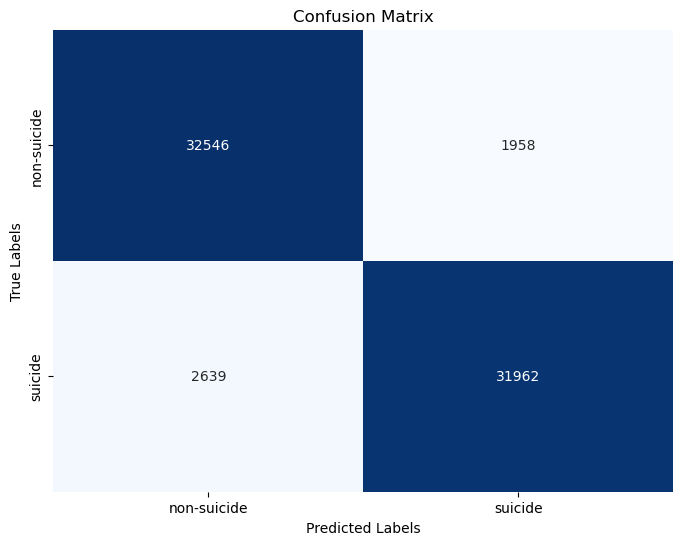

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# decode the labels back to original
reverse_mapping = {1: 'suicide', 0: 'non-suicide'}
decoded_y_pred = [reverse_mapping[label] for label in y_pred]
decoded_y_test = [reverse_mapping[label] for label in y_test]

# create confusion matrix
conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['non-suicide', 'suicide'])
plt.yticks(ticks=[0.5, 1.5], labels=['non-suicide', 'suicide'])
plt.show()

Plot ROC Curve (SVM Based Model)

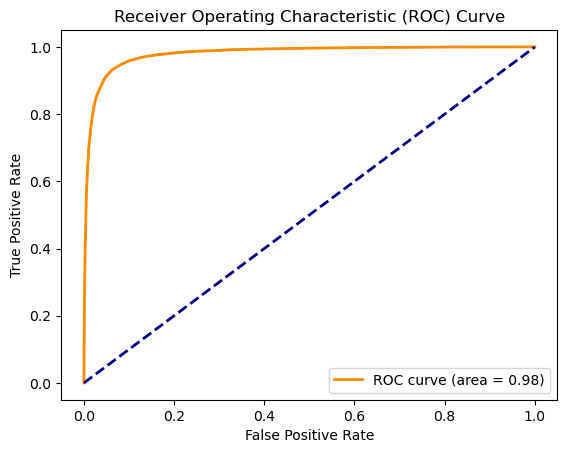

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC curve 
y_pred_proba = svm_model.decision_function(X_test_tfidf)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Grid Search for Hypertuning with 3 Hyperparameters 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create SVC classifier
svm_model = SVC()

# Define hyperparameters to tune
param_grid = {
    'C': [1, 5],
    'kernel': ['linear', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Make predictions on the test set using the best model
best_svm = grid_search.best_estimator_
predictions_test = best_svm.predict(X_test_tfidf)

# Calculate accuracy score on the test set
best_svm_train_score = best_svm.score(X_train_tfidf, y_train)
best_svm_test_score = best_svm.score(X_test_tfidf, y_test)

print()
print("Best SVM Model:")
print("Training Score: {}\nTest Score: {}".format(best_svm_train_score, best_svm_test_score))

print("\nClassification Report:")
print(classification_report(y_test, predictions_test))

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.9282631201493643

Best SVM Model:
Training Score: 0.9411133575619256
Test Score: 0.9290644671152594

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     34504
           1       0.94      0.92      0.93     34601

    accuracy                           0.93     69105
   macro avg       0.93      0.93      0.93     69105
weighted avg       0.93      0.93      0.93     69105



Plot Confusion Matrix for the Best SVM model (After Tuning)

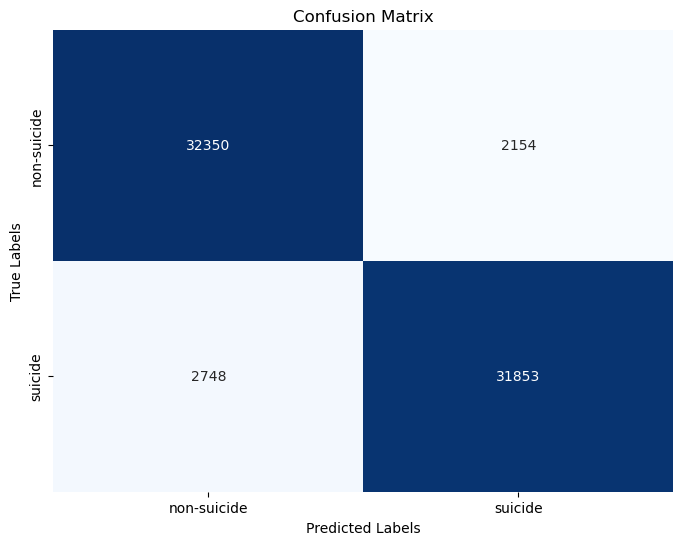

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# decode the labels back to original
reverse_mapping = {1: 'suicide', 0: 'non-suicide'}
decoded_y_pred = [reverse_mapping[label] for label in predictions_test]
decoded_y_test = [reverse_mapping[label] for label in y_test]

# create confusion matrix
conf_matrix = confusion_matrix(decoded_y_test, decoded_y_pred)

# plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['non-suicide', 'suicide'])
plt.yticks(ticks=[0.5, 1.5], labels=['non-suicide', 'suicide'])
plt.show()

Plot ROC Curve for the Best SVM model (After Tuning)

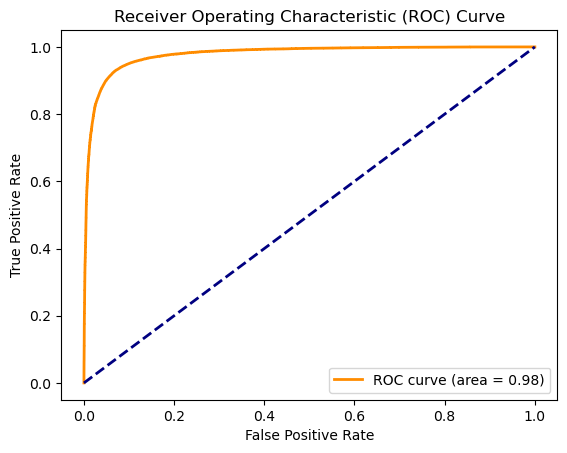

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC curve 
y_pred_proba = best_svm.decision_function(X_test_tfidf)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Save Best Model and TF-IDF Vectorizer 

In [12]:
# save model and vectorizer
import joblib

joblib.dump(best_svm, 'best_svm_model.pkl')
print('SVM Best model saved')

joblib.dump(tfidf_vectorizer, 'svm_tfidf_vectorizer.pkl')
print('SVM TFIDF vectorizer saved')

SVM Best model saved
SVM TFIDF vectorizer saved


Test on Random Unseen Data (Optional)

In [13]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# load the saved model and tfidf vectorizer
model_filename = 'best_svm_model.pkl'
vectorizer_filename = 'svm_tfidf_vectorizer.pkl'

model = joblib.load(model_filename)
vectorizer = joblib.load(vectorizer_filename)

# encode the label
label_encoding = {0: 'non-suicide', 1: 'suicide'}

# unseen data
input_text = "i want die because my life is never happy."

# vector the unseen data
transformed_input = vectorizer.transform([input_text])

# predit the unseen data by usig saved model
prediction = model.predict(transformed_input)

# decode the label into its original class
decoded_prediction = label_encoding[prediction[0]]

# print result
print(f"Prediction: {decoded_prediction}")

Prediction: suicide
